# Term Project - Eric Xiao (Group 34)

In [1]:
# PLEASE RUN THIS ONE TIME

library(tidyverse)
first_time_ran <- TRUE

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## 1. Dataset Description

This dataset consists of two files: `players.csv` contains data about all the players and `sessions.csv` contains data about the play sessions that participants had.

**NOTE: the variables (column names) have been renamed to be PascalCase since they were previously not consistent**

*The following markdown tables were made using https://www.tablesgenerator.com/markdown_tables*

### Players.csv

There are a total of 7 variables and 196 observations.

| Variable    | Type | Interpreted Meaning                                                          | Statistical Summary                                          | Possible Issues                                                                                                                                 |
|-------------|------|------------------------------------------------------------------------------|--------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| Experience  | chr  | The amount of experience the player has with Minecraft                       | 35 Beginners, 63 Amateurs, 36 Regulars, 14 Pros, 48 Veterans | **Should convert type into fct.** The distinction between some of these labels such as "pro" and "veteran" are not that clear in their meanings |
| Subscribe   | lgl  | Represents whether or not the player subscribed to a game-related newsletter | 52 not subscribed, 144 subscribed to the newsletter          | N/A                                                                                                                                             |
| HashedEmail | chr  | The email of the player, which has been hashed for their privacy             | N/A                                                          | Not really any uses for this variable in terms of data analysis                                                                                 |
| PlayedHours | dbl  | The total number of hours that the player has played on the server           | Average of 5.84 hours played                                 | Some players have 0 hours played                                                                                                                |
| Name        | chr  | Their name                                                                   | N/A                                                          | Not really any uses for this variable in terms of data analysis                                                                                 |
| Gender      | chr  | Their gender                                                                 | 124 Male, 37 Female, 35 other gender minorities              | **Should convert type into fct.** There is a large difference in number of female and male players                                              |
| Age         | dbl  | Their age                                                                    | Average age of 21.14                                         | Two players have NA as their age                                                                                                                |

### Sessions.csv

There are a total of 5 variables and 1535 observations.

| Variable          | Type | Interpreted Meaning                                                 | Statistical Summary                               | Possible Issues                                                                                                                             |
|-------------------|------|---------------------------------------------------------------------|---------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| HashedEmail       | chr  | The email of the player playing in this session, hashed for privacy | N/A                                               | Cannot be used for data analysis, but can be used to match the player in `players.csv` to the session                                       |
| StartTime         | chr  | The starting time of the play session                               | Average session duration 51 minutes\*             | Not formatted well to be interpreted as a time, should either split into multiple columns, **OR parse datetime string into dttm**           |
| EndTime           | chr  | The end time of the play session                                    | Longest session was 4 hours 19 minutes\*          | *Same issues as StartTime*                                                                                                                  |
| OriginalStartTime | dbl  | The Unix timestamp in milliseconds, representing the start time     | First session started on Apr 06 2024 (1.7124e+12) | Since we already have StartTime, this is not really necessary and is less accurate since it only goes to ±10000000 milliseconds = ±2h 46min |
| OriginalEndTime   | dbl  | The Unix timestamp in milliseconds, representing the end time       | Last session ended on Sep 26 2024 (1.72734e+12)   | *Same issues as OriginalStartTime*                                                                                                          |

\* = used multiple variables for statistic summary

## 2. Questions

Selected broad question: *What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? (question 1)*

Specific question: **Can a player's age, total hours played, experience, and average play time duration within a session predict if a player would subscribe to a game-related newsletter using the players and sessions dataset?**

This is a classification problem, so we use predictive variables to classify a player as subscribing or not subscribing to a game-related newsletter.

The `players.csv` data can easily be used since it has many variables that directly relate to a player. However, the `sessions.csv` data can also be used since the hashed email can be linked to a player. One possible metric from `sessions.csv` is the average session duration that the player plays for; we can group by email, create a new column called AverageSessionDuration based on EndTime - StartTime, and summarize an average for each email. Then, we can use bind_col to add AverageSessionDuration to players and use it as a predictive variable.

After wrangling the data, we can use k-nn classification to train a model, but we should probably separate our data into training/testing, tune for the best k-value, then retrain, and apply the model on the testing set to determine how good our model is.

One concern is the number of observations for players, because there are only 196 players in this dataset.

## 3. Exploratory Data Analysis and Visualization

> Note that the report of mean values of quantitative variables in `players.csv` are already present in [section 1](#Players.csv)  
> (The code that computes these values are located near the end of the notebook)

Below is some code that makes the two datasets tidy.

There are also some visualizations that relate to the research question about whether or not we can predict newsletter subscription status based on the player characteristics and behaviors.

### Experience Plot

This plot explores if players with different experience with Minecraft have different perentage that subscribe to the newsletter. The average percentage is about 75%, with pro, veteran, and amateur players subscribing a bit less than average, however, it is unclear whether or not to consider this statistically significant.

### Gender Plot

This plot explores if players of different gender have different likelihood of subscribing to the newsletter. There does not seem to be a statistically significant difference between male and female players, and the other gender minorities do show some interesting trends but they only represent a few observations.

### Hours Played and Age Plot

This scatter plot shows Hours Played vs Age, and colors points based on if they subscribed to the newsletter. It shows that players that have played a lot (> 20 hours) are almost guaranteed to be subscribed, while there is no clear trend within 1 - 6 hours of play time (this is shown through 2 plots, one zoomed in more).

In [2]:
players <- read_csv("https://raw.githubusercontent.com/avahbot/dsci-100-term-project/27334598713332bcae2f0dfbe56513e06786391f/data/players.csv") |>
    rename(Experience = experience,
           Subscribe = subscribe,
           HashedEmail = hashedEmail,
           PlayedHours = played_hours,
           Name = name,
           Gender = gender,
           Age = Age) # technically doesn't need to be here

sessions <- read_csv("https://raw.githubusercontent.com/avahbot/dsci-100-term-project/27334598713332bcae2f0dfbe56513e06786391f/data/sessions.csv") |>
    rename(HashedEmail = hashedEmail,
           StartTime = start_time,
           EndTime = end_time,
           OriginalStartTime = original_start_time,
           OriginalEndTime = original_end_time)

Rows: 196 Columns: 7
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Guard to make sure it doesn't try and parse the Start/EndTime multiple times, causing error
if (first_time_ran) {
    # Experience and Gender should be converted into factors
    players <- players |> mutate(Experience = as_factor(Experience), Gender = as_factor(Gender))

    # Start and End Time should be datetime variables (Other way is to separate them into different columns)
    sessions <- sessions |> mutate(StartTime = dmy_hm(StartTime), EndTime = dmy_hm(EndTime))

    first_time_ran <- FALSE
}

head(players)
head(sessions)

Experience,Subscribe,HashedEmail,PlayedHours,Name,Gender,Age
<fct>,<lgl>,<chr>,<dbl>,<chr>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


HashedEmail,StartTime,EndTime,OriginalStartTime,OriginalEndTime
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,1.71916e+12,1.71916e+12


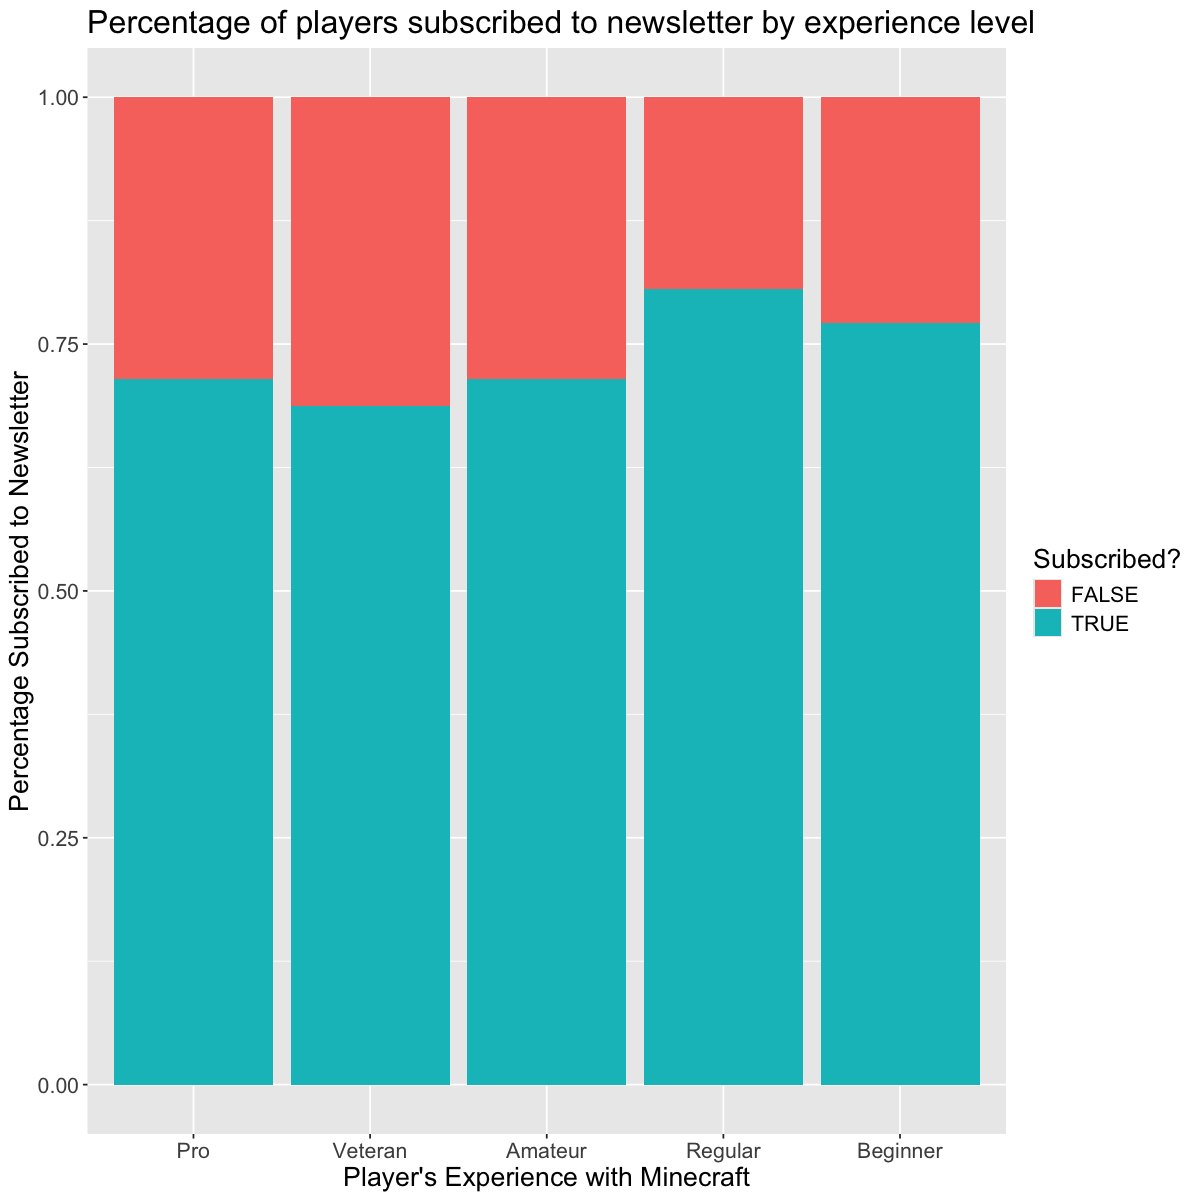

In [4]:
# Does experience level of player affect their likelihood of subscribing?
options(repr.plot.width = 10, repr.plot.height = 10)

players |> ggplot(aes(x = Experience, fill = Subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Player's Experience with Minecraft", y = "Percentage Subscribed to Newsletter", fill = "Subscribed?") +
    ggtitle("Percentage of players subscribed to newsletter by experience level") +
    theme(text = element_text(size = 16))

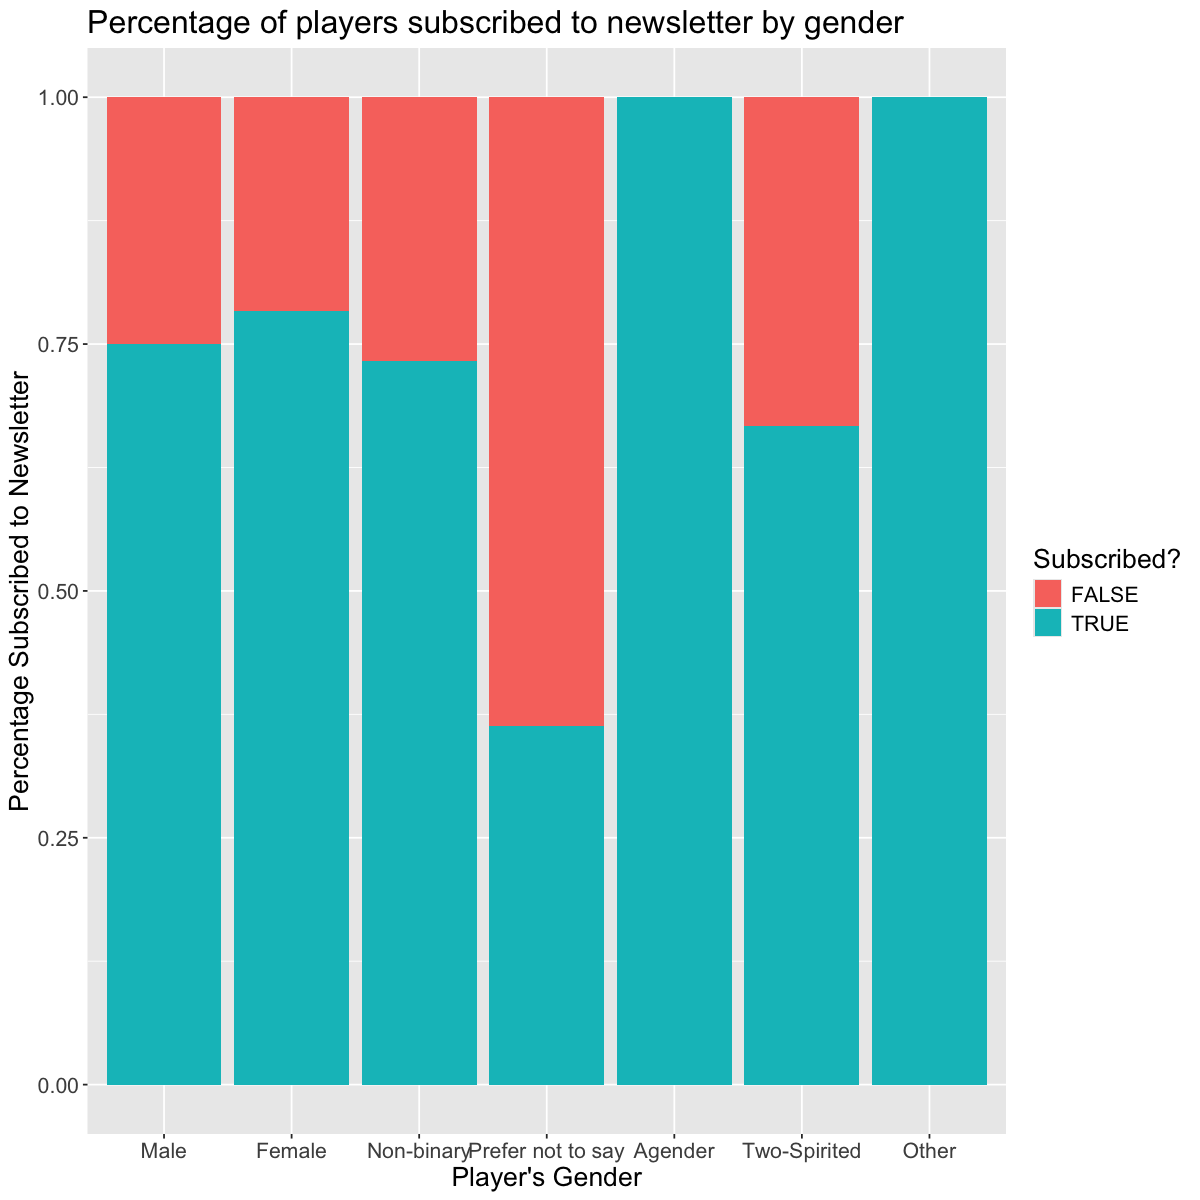

In [5]:
# Does gender of player affect their likelihood of subscribing?
options(repr.plot.width = 10, repr.plot.height = 10)

players |> ggplot(aes(x = Gender, fill = Subscribe)) +
    geom_bar(position = "fill") +
    labs(x = "Player's Gender", y = "Percentage Subscribed to Newsletter", fill = "Subscribed?") +
    ggtitle("Percentage of players subscribed to newsletter by gender") +
    theme(text = element_text(size = 16))

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 16 rows containing missing values or values outside the scale range (`geom_point()`).”


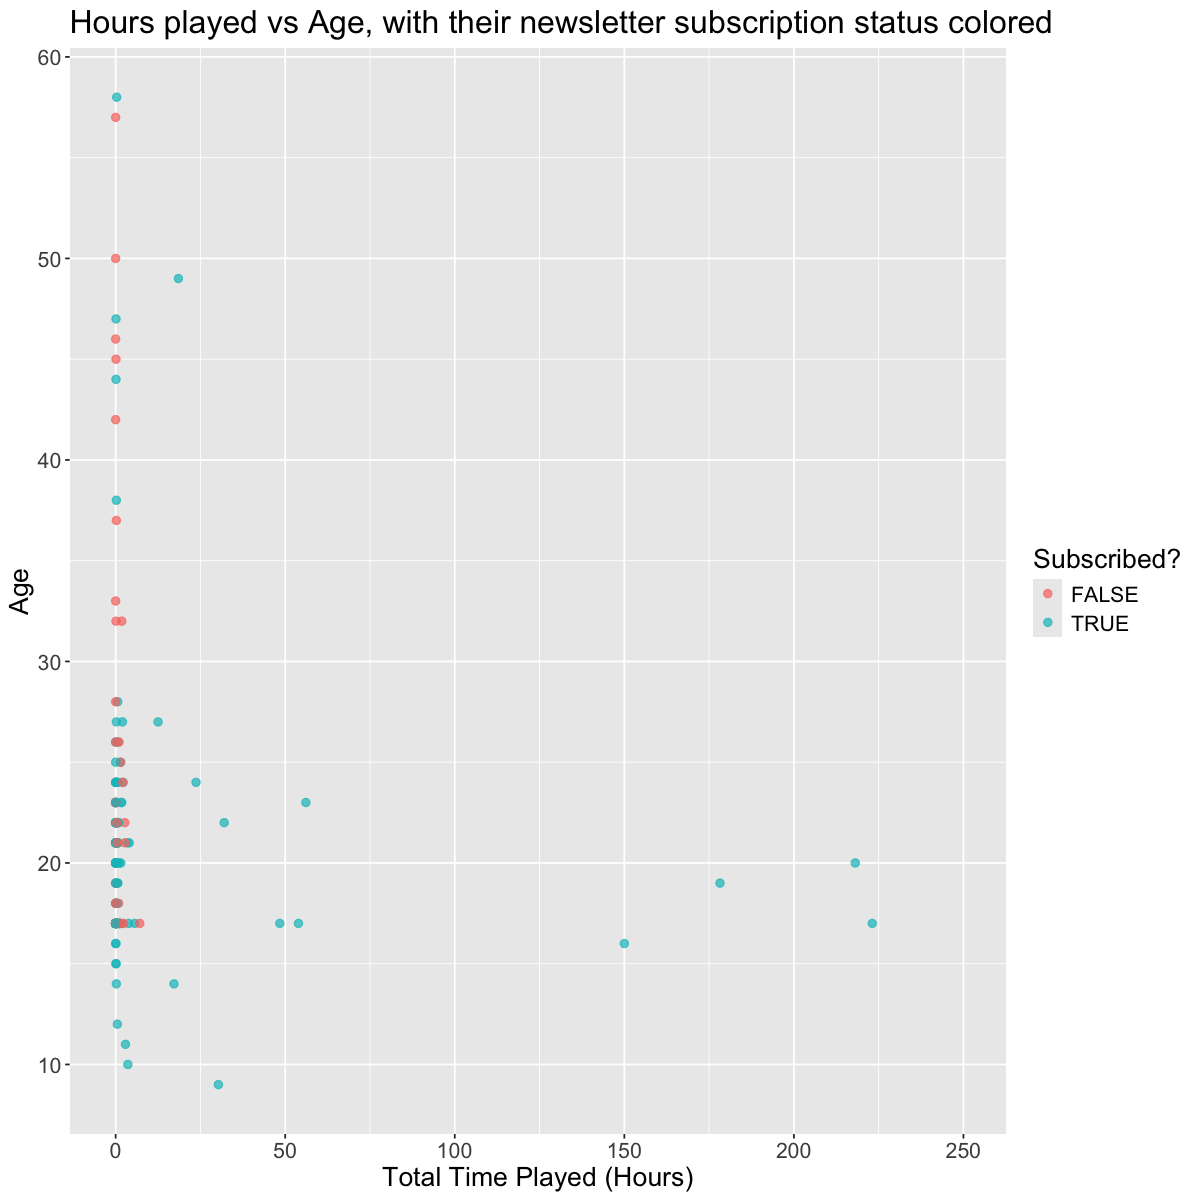

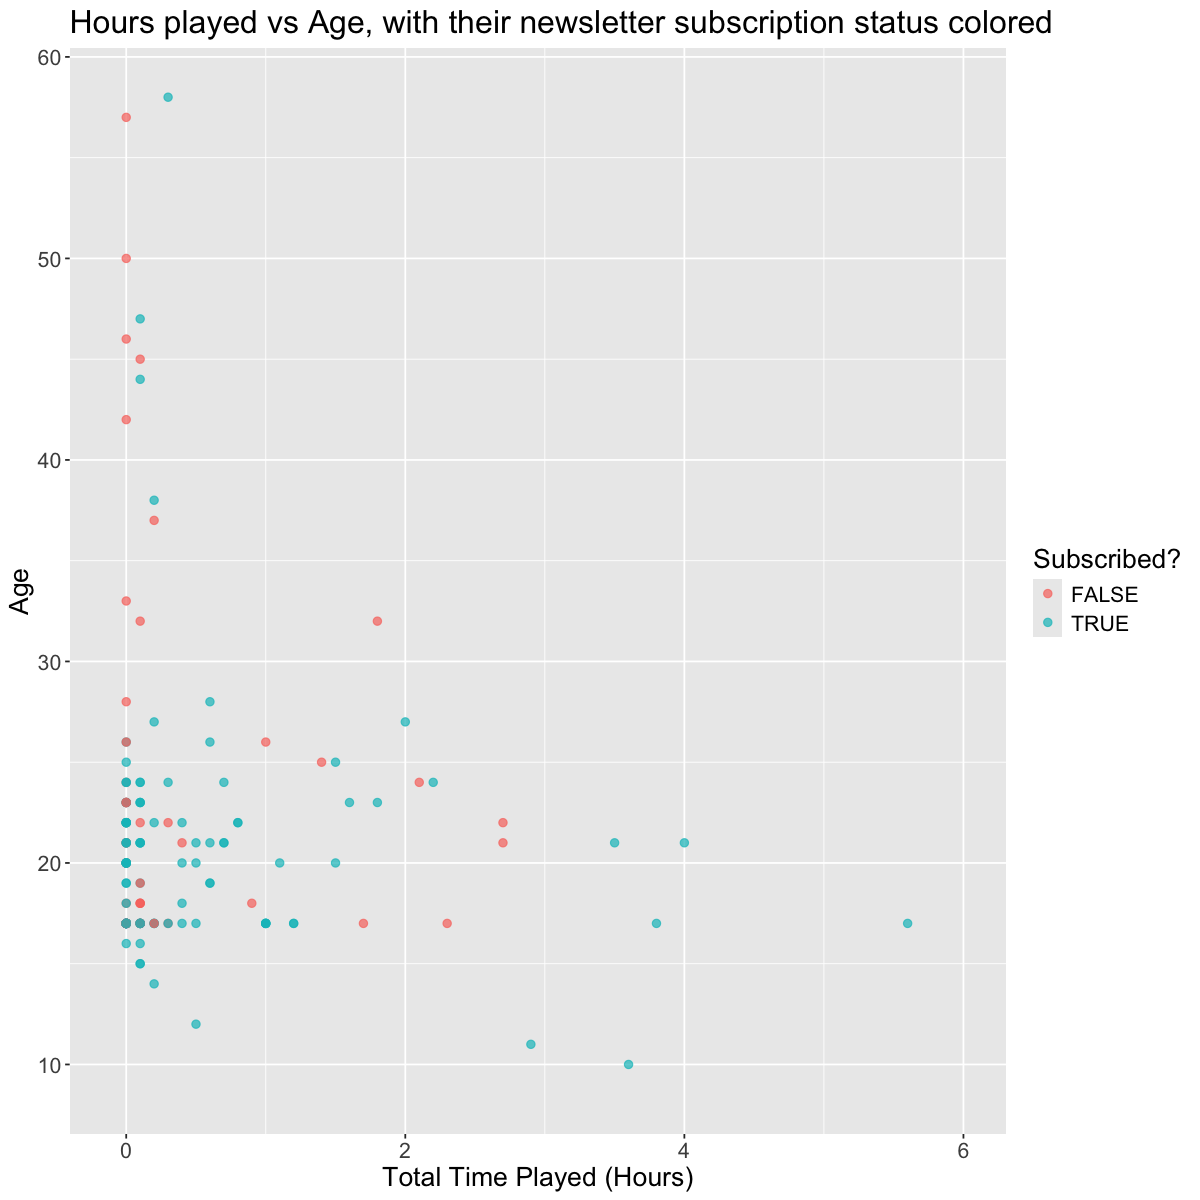

In [6]:
# Does play time of player and age affect their likelihood of subscribing?
options(repr.plot.width = 10, repr.plot.height = 10)

playtime_age_subscribed_plot <- players |> ggplot(aes(x = PlayedHours, y = Age, color = Subscribe)) +
    geom_point(size = 2, alpha = 0.7) +
    labs(x = "Total Time Played (Hours)", y = "Age", color = "Subscribed?") +
    ggtitle("Hours played vs Age, with their newsletter subscription status colored") +
    theme(text = element_text(size = 16)) +
    scale_x_log10()

playtime_age_subscribed_plot + xlim(-1, 250)

playtime_age_subscribed_plot + xlim(-0.1, 6)

## 5. Github

The github repository link for this project is here: https://github.com/avahbot/dsci-100-term-project

## 6. Appendix

In [7]:
# Used to get variable statistical summaries

players |> group_by(Experience) |> summarize(count = n())
players |> group_by(Subscribe) |> summarize(count = n())
players |> group_by(Gender) |> summarize(count = n())
players |> summarize(average_hours_played = mean(PlayedHours))
players |> summarize(average_age = mean(Age, na.rm = TRUE))
sessions |> summarize(first_session_start_time = min(OriginalStartTime))
sessions |> summarize(last_session_end_time = max(OriginalEndTime, na.rm = TRUE))

sessions |> summarize(average_session_duration = mean(EndTime - StartTime, na.rm = TRUE))
sessions |> summarize(max_session_duration = max(EndTime - StartTime, na.rm = TRUE))

Experience,count
<fct>,<int>
Pro,14
Veteran,48
Amateur,63
Regular,36
Beginner,35


Subscribe,count
<lgl>,<int>
FALSE,52
TRUE,144


Gender,count
<fct>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Agender,2
Two-Spirited,6
Other,1


average_hours_played
<dbl>
5.845918


average_age
<dbl>
21.13918


first_session_start_time
<dbl>
1.7124e+12


last_session_end_time
<dbl>
1.72734e+12


average_session_duration
<drtn>
50.85845 mins


max_session_duration
<drtn>
259 mins
